<h1>Asan Dopollos Model</h1>

------
# Imports
------

In [211]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


# Import datasets
network = pd.read_csv('network.csv')
inspections = pd.read_csv('inspections.csv')
pipes = pd.read_csv('sample_submission.csv')
weather = pd.read_csv('temperature.csv')

-----
# Data Visualization
-----

In [212]:
network.head()

,PipeId,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle
0,489616,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,63.0,7.792,0.4,0,0,False
1,489645,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,90.0,2.080,0.4,0,0,False
2,489646,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,90.0,111.173,0.4,3,0,False
3,519950,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,200.0,14.304,0.4,0,0,False
4,1332439,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,160.0,22.669,0.4,1,0,False


In [213]:
pipes.head()

,PipeId,Incidence
0,446859944,0
1,428124500,0
2,438428871,0
3,429034569,0
4,411184477,0


In [214]:
inspections.head()

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence
0,189311802,ZRV-00001972,2010,2010-10-01,24,4,0
1,188889914,ZRV-00001406,2010,2010-10-01,22,4,0
2,188889907,ZRV-00001406,2010,2010-10-01,22,4,0
3,188673355,ZRV-00001406,2010,2010-10-01,22,4,0
4,188558922,ZRV-00001406,2010,2010-10-01,22,4,0


## External data processing

In [215]:
weather = weather.drop(['datetime','tempmax','tempmin', 'temp', 'humidity', 'solarradiation', 'uvindex'],axis=1)
# drop duplicates
weather = weather.drop_duplicates()
# Change value type
weather['max_temp_year'] = weather['max_temp_year'].astype('float')
weather['min_temp_year'] = weather['min_temp_year'].astype('float')
weather['avg_temp_year'] = weather['avg_temp_year'].astype('float')
weather['avg_humid_year'] = weather['avg_humid_year'].astype('float')

weather.head()

,Province,InspectionYear,max_temp_year,min_temp_year,avg_temp_year,avg_humid_year
0,León,2010,33.1,-12.0,10.032055,72.990685
365,León,2011,33.0,-11.0,11.165479,71.784110
730,León,2012,34.2,-10.0,10.470219,68.450546
1096,León,2013,35.8,-9.0,10.120548,73.955890
1461,León,2014,33.4,-8.8,10.956986,72.493151


## Dataframe merging

Merging the df with an inner join using PipeId

In [216]:
# Merge dataframes
df = inspections.merge(
                        network,
                        how = 'inner',
                        on=['PipeId'] 
                        )

df = df.merge(
                        weather,
                        how = 'left',
                        on=['Province', 'InspectionYear'] 
                        )

df

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,...,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,max_temp_year,min_temp_year,avg_temp_year,avg_humid_year
0,189311802,ZRV-00001972,2010,2010-10-01,24,4,0,Barcelona,Sentmenat,2001,...,160.0,117.831,4.000,0,0,False,34.4,-2.0,15.674795,67.626849
1,189311802,ZRV-00001972,2012,2012-10-01,24,4,0,Barcelona,Sentmenat,2001,...,160.0,117.831,4.000,0,0,False,34.9,-3.7,17.059016,65.362842
2,189311802,ZRV-00001972,2014,2014-10-08,24,4,0,Barcelona,Sentmenat,2001,...,160.0,117.831,4.000,0,0,False,31.9,0.6,17.215890,72.549589
3,189311802,ZRV-00001972,2016,2016-10-14,24,4,0,Barcelona,Sentmenat,2001,...,160.0,117.831,4.000,0,0,False,32.6,0.7,17.004098,70.247541
4,189311802,ZRV-00001972,2018,2018-10-09,24,4,0,Barcelona,Sentmenat,2001,...,160.0,117.831,4.000,0,0,False,34.8,-0.3,17.161370,71.579452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345339,56922448,ZRV-00004581,2020,2020-12-31,24,4,0,Valencia,Betera,1993,...,63.0,1.237,4.000,0,0,False,33.8,0.2,18.379781,66.201913
6345340,56907425,ZRV-00004581,2020,2020-12-31,24,4,0,Valencia,Betera,2000,...,160.0,169.732,4.000,1,0,False,33.8,0.2,18.379781,66.201913
6345341,7843615,ZRV-00002112,2021,2020-12-31,24,4,0,Barcelona,Sabadell,1995,...,150.0,0.361,0.025,0,0,True,33.1,-1.3,16.905479,76.068767
6345342,56922456,ZRV-00004581,2020,2020-12-31,24,4,0,Valencia,Betera,1993,...,63.0,23.306,4.000,0,0,False,33.8,0.2,18.379781,66.201913


| Field               | Meaning                                              |
|---------------------|------------------------------------------------------|
| PipeId              | Unique identifier for the pipe                       |
| Province            | Spanish province where the pipe is located           |
| Town                | Town or city where the pipe is located               |
| YearBuilt           | Year in which the pipe was built and installed       |
| Material            | Material in which the pipe is built                  | 
| GasType             | Type of gas that runs through the pipe               |
| Diameter            | Diameter of the pipe (in mm)                         |
| Length              | Length of the pipe (in m)                            |
| Pressure            | Pressure of the gas that runs through the pipe (bar) |
| NumConnections      | Number of connections (external)                     |
| NumConnectionsUnder | Number of connections (internal and buried)          |
| BoolBridle          | Whether the pipe is bridled (True) or welded (False) |



----
# Data preparation
----

Dates will be converted to datetime.

In [217]:
df['InspectionDate'] = pd.to_datetime(df['InspectionDate'])

Column Dop: MaintenaceId, Town, NumConnectionsUnder

In [218]:
df = df.drop(['MaintenanceId','NumConnectionsUnder','Town'],axis=1)
df

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle,max_temp_year,min_temp_year,avg_temp_year,avg_humid_year
0,189311802,2010,2010-10-01,24,4,0,Barcelona,2001,PE,Gas natural,160.0,117.831,4.000,0,False,34.4,-2.0,15.674795,67.626849
1,189311802,2012,2012-10-01,24,4,0,Barcelona,2001,PE,Gas natural,160.0,117.831,4.000,0,False,34.9,-3.7,17.059016,65.362842
2,189311802,2014,2014-10-08,24,4,0,Barcelona,2001,PE,Gas natural,160.0,117.831,4.000,0,False,31.9,0.6,17.215890,72.549589
3,189311802,2016,2016-10-14,24,4,0,Barcelona,2001,PE,Gas natural,160.0,117.831,4.000,0,False,32.6,0.7,17.004098,70.247541
4,189311802,2018,2018-10-09,24,4,0,Barcelona,2001,PE,Gas natural,160.0,117.831,4.000,0,False,34.8,-0.3,17.161370,71.579452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345339,56922448,2020,2020-12-31,24,4,0,Valencia,1993,PE,Gas natural,63.0,1.237,4.000,0,False,33.8,0.2,18.379781,66.201913
6345340,56907425,2020,2020-12-31,24,4,0,Valencia,2000,PE,Gas natural,160.0,169.732,4.000,1,False,33.8,0.2,18.379781,66.201913
6345341,7843615,2021,2020-12-31,24,4,0,Barcelona,1995,FD,Gas natural,150.0,0.361,0.025,0,True,33.1,-1.3,16.905479,76.068767
6345342,56922456,2020,2020-12-31,24,4,0,Valencia,1993,PE,Gas natural,63.0,23.306,4.000,0,False,33.8,0.2,18.379781,66.201913


Severity values will be inverted, meaning that they will go from 0-3 going from no incidence to highest severity

In [219]:
inverse_sev = {4:0,3:1,2:2,1:3}
list = []
for sev in df["Severity"]:
    list.append(inverse_sev[sev]) 

df['Severity'] = list
df

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle,max_temp_year,min_temp_year,avg_temp_year,avg_humid_year
0,189311802,2010,2010-10-01,24,0,0,Barcelona,2001,PE,Gas natural,160.0,117.831,4.000,0,False,34.4,-2.0,15.674795,67.626849
1,189311802,2012,2012-10-01,24,0,0,Barcelona,2001,PE,Gas natural,160.0,117.831,4.000,0,False,34.9,-3.7,17.059016,65.362842
2,189311802,2014,2014-10-08,24,0,0,Barcelona,2001,PE,Gas natural,160.0,117.831,4.000,0,False,31.9,0.6,17.215890,72.549589
3,189311802,2016,2016-10-14,24,0,0,Barcelona,2001,PE,Gas natural,160.0,117.831,4.000,0,False,32.6,0.7,17.004098,70.247541
4,189311802,2018,2018-10-09,24,0,0,Barcelona,2001,PE,Gas natural,160.0,117.831,4.000,0,False,34.8,-0.3,17.161370,71.579452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345339,56922448,2020,2020-12-31,24,0,0,Valencia,1993,PE,Gas natural,63.0,1.237,4.000,0,False,33.8,0.2,18.379781,66.201913
6345340,56907425,2020,2020-12-31,24,0,0,Valencia,2000,PE,Gas natural,160.0,169.732,4.000,1,False,33.8,0.2,18.379781,66.201913
6345341,7843615,2021,2020-12-31,24,0,0,Barcelona,1995,FD,Gas natural,150.0,0.361,0.025,0,True,33.1,-1.3,16.905479,76.068767
6345342,56922456,2020,2020-12-31,24,0,0,Valencia,1993,PE,Gas natural,63.0,23.306,4.000,0,False,33.8,0.2,18.379781,66.201913


-----
# Feature Engineering
-----

## Material properties
Table with the material type:

|Material Type | Corrodes | Young's Module (GPa) |
|--------------|----------|----------------------|
|AO: aluminum oxide     | No     |  380 |
|CU: copper     | Yes     | 120 |
|FD: ductil function     | No     |  172 |
|FG: fiber glass     | No     | 50 |
|FI: flame inhibitant     | No     | 4 |
|FO: unkown     | No     | 4 |
|PA: polyamid     | No     | 6 |
|PE: polyehtylene     | No     | 1 | 
|PN: polyethylene naphthalate     | No     | 4.5 |
|PV: polyvinyl      | No     | 4 | 
|ZD: zinc diecasting     | No     | 100 |

In [220]:
# Adding corrosive properties to the elements
df ['Corrosive'] = 0
indices = df[df.Material == 'CU'].index
df['Corrosive'][indices] = 1
# Adding Youngs Modulus to see which ones are more prone to cracks
youngs_dict = {'AO':380,'CU':120,'FD':172,'FG':50,'FI':4,'FO':4,'PA':6,'PE':1,'PN':4.5,'PV':4,'ZD':100}
lst = []
for idx in df.index:
    lst.append(youngs_dict[df['Material'][idx]])

df['Youngs_Mod'] = lst
df

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_63504/4004144257.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Corrosive'][indices] = 1


,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,...,Length,Pressure,NumConnections,BoolBridle,max_temp_year,min_temp_year,avg_temp_year,avg_humid_year,Corrosive,Youngs_Mod
0,189311802,2010,2010-10-01,24,0,0,Barcelona,2001,PE,Gas natural,...,117.831,4.000,0,False,34.4,-2.0,15.674795,67.626849,0,1.0
1,189311802,2012,2012-10-01,24,0,0,Barcelona,2001,PE,Gas natural,...,117.831,4.000,0,False,34.9,-3.7,17.059016,65.362842,0,1.0
2,189311802,2014,2014-10-08,24,0,0,Barcelona,2001,PE,Gas natural,...,117.831,4.000,0,False,31.9,0.6,17.215890,72.549589,0,1.0
3,189311802,2016,2016-10-14,24,0,0,Barcelona,2001,PE,Gas natural,...,117.831,4.000,0,False,32.6,0.7,17.004098,70.247541,0,1.0
4,189311802,2018,2018-10-09,24,0,0,Barcelona,2001,PE,Gas natural,...,117.831,4.000,0,False,34.8,-0.3,17.161370,71.579452,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345339,56922448,2020,2020-12-31,24,0,0,Valencia,1993,PE,Gas natural,...,1.237,4.000,0,False,33.8,0.2,18.379781,66.201913,0,1.0
6345340,56907425,2020,2020-12-31,24,0,0,Valencia,2000,PE,Gas natural,...,169.732,4.000,1,False,33.8,0.2,18.379781,66.201913,0,1.0
6345341,7843615,2021,2020-12-31,24,0,0,Barcelona,1995,FD,Gas natural,...,0.361,0.025,0,True,33.1,-1.3,16.905479,76.068767,0,172.0
6345342,56922456,2020,2020-12-31,24,0,0,Valencia,1993,PE,Gas natural,...,23.306,4.000,0,False,33.8,0.2,18.379781,66.201913,0,1.0


## Value Normalization

In [221]:
for column in ['Diameter', 'Length', 'Pressure', 'Youngs_Mod', 'max_temp_year', 'min_temp_year', 'avg_temp_year', 'avg_humid_year']:
   df[column] = (df[column] - df[column].mean()) / df[column].std()

## Age of the pipe

In [222]:
df['Age'] = df["InspectionYear"] - df["YearBuilt"]

## Severity of the previous inspection

In [223]:
df = df.sort_values(['PipeId','InspectionDate'])
df = df.reset_index(drop=True)

prev_sev = 0
previous_severity = []

for ind in df.index:
    previous_severity.append(prev_sev)
    prev_sev = df['Severity'][ind]

df['PrevSeverity'] = previous_severity

# Change first instance of the values
idx = df.loc[df.groupby('PipeId').cumcount() == 0]['PrevSeverity'].index
df['PrevSeverity'][idx] = 0

df

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_63504/2927278767.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PrevSeverity'][idx] = 0


,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,...,NumConnections,BoolBridle,max_temp_year,min_temp_year,avg_temp_year,avg_humid_year,Corrosive,Youngs_Mod,Age,PrevSeverity
0,489616,2013,2013-05-08,16,0,0,Ciudad Real,2012,PE,Gas natural,...,0,False,1.017163,-1.497136,-1.179279,-0.217830,0,-0.35414,1,0
1,489616,2015,2015-03-04,22,0,0,Ciudad Real,2012,PE,Gas natural,...,0,False,1.298689,-1.164203,-0.209350,-1.342438,0,-0.35414,3,0
2,489616,2016,2017-01-12,22,0,0,Ciudad Real,2012,PE,Gas natural,...,0,False,0.766919,-0.498336,-0.050999,-0.984877,0,-0.35414,4,0
3,489616,2018,2018-12-19,23,0,0,Ciudad Real,2012,PE,Gas natural,...,0,False,0.923322,-0.897856,-0.519527,-0.612774,0,-0.35414,6,0
4,489616,2020,2020-12-05,24,0,0,Ciudad Real,2012,PE,Gas natural,...,0,False,1.267408,-0.531629,-0.055428,-0.803717,0,-0.35414,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345339,451995260,2019,2019-10-23,24,0,0,Lleida,2003,PE,Gas natural,...,2,False,1.204847,-0.631509,-0.404912,-0.369567,0,-0.35414,16,0
6345340,451995309,2013,2013-10-07,24,0,0,Lleida,1998,PE,Gas natural,...,0,False,-0.327901,-0.298576,-0.439153,0.543294,0,-0.35414,15,0
6345341,451995309,2015,2015-10-05,24,0,0,Lleida,1998,PE,Gas natural,...,0,False,1.705336,-0.531629,-0.362361,0.292382,0,-0.35414,17,0
6345342,451995309,2017,2017-10-02,24,0,0,Lleida,1998,PE,Gas natural,...,0,False,0.860761,-1.463843,-0.494311,0.036891,0,-0.35414,19,0


## Seismic activity

The accumulated number of seisms in total and between revisions will be used. Firstly the dataframe is loaded and a merge_asof is done

In [224]:
df_seism = pd.read_csv('Sismic_activity_dataframe.csv')
# Seism dates to datetimes
df_seism['Fecha'] = pd.to_datetime(df_seism['Fecha'])
# Merging using the closest date to the df
df = pd.merge_asof(df.sort_values(by='InspectionDate'),df_seism.sort_values(by='Fecha')
            ,left_on=['InspectionDate'],right_on=['Fecha'],by='Province')

# Order the rows
df = df.sort_values(['PipeId','InspectionDate'])

Now, the acumulated variables are obtained

In [225]:
# Order the rows
df = df.drop(['Fecha','Year','Seism'],axis=1)
# Taking the difference bewteen elements of the same column
df['AcumSeismRev'] = df['AcumSeism'].diff()
df = df.fillna(value=0)
df = df.sort_values(['PipeId','InspectionDate'])

idx = df.loc[df.groupby('PipeId').cumcount() == 0]['AcumSeismRev'].index 
df['AcumSeismRev'][idx] = 0


df = df.reset_index(drop=True)
df

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_63504/1936198396.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AcumSeismRev'][idx] = 0


,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,...,max_temp_year,min_temp_year,avg_temp_year,avg_humid_year,Corrosive,Youngs_Mod,Age,PrevSeverity,AcumSeism,AcumSeismRev
0,489616,2013,2013-05-08,16,0,0,Ciudad Real,2012,PE,Gas natural,...,1.017163,-1.497136,-1.179279,-0.217830,0,-0.35414,1,0,62.0,0.0
1,489616,2015,2015-03-04,22,0,0,Ciudad Real,2012,PE,Gas natural,...,1.298689,-1.164203,-0.209350,-1.342438,0,-0.35414,3,0,96.0,34.0
2,489616,2016,2017-01-12,22,0,0,Ciudad Real,2012,PE,Gas natural,...,0.766919,-0.498336,-0.050999,-0.984877,0,-0.35414,4,0,139.0,43.0
3,489616,2018,2018-12-19,23,0,0,Ciudad Real,2012,PE,Gas natural,...,0.923322,-0.897856,-0.519527,-0.612774,0,-0.35414,6,0,159.0,20.0
4,489616,2020,2020-12-05,24,0,0,Ciudad Real,2012,PE,Gas natural,...,1.267408,-0.531629,-0.055428,-0.803717,0,-0.35414,8,0,206.0,47.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345339,451995260,2019,2019-10-23,24,0,0,Lleida,2003,PE,Gas natural,...,1.204847,-0.631509,-0.404912,-0.369567,0,-0.35414,16,0,1991.0,667.0
6345340,451995309,2013,2013-10-07,24,0,0,Lleida,1998,PE,Gas natural,...,-0.327901,-0.298576,-0.439153,0.543294,0,-0.35414,15,0,383.0,0.0
6345341,451995309,2015,2015-10-05,24,0,0,Lleida,1998,PE,Gas natural,...,1.705336,-0.531629,-0.362361,0.292382,0,-0.35414,17,0,650.0,267.0
6345342,451995309,2017,2017-10-02,24,0,0,Lleida,1998,PE,Gas natural,...,0.860761,-1.463843,-0.494311,0.036891,0,-0.35414,19,0,1324.0,674.0


## Accumulated Incidences and Revisions

In [226]:
accum_incidence_list = [0]
incidence_count = df['Incidence'][0]
revision_count = 1
revision_list = [0]

for ind in range(1, len(df.index)):
    if df['PipeId'][ind] != df['PipeId'][ind-1]:
        incidence_count = 0
        revision_count = 0
    accum_incidence_list.append(incidence_count)
    revision_list.append(revision_count)
    incidence_count = incidence_count + df['Incidence'][ind]
    revision_count += 1

df['AcumIncidence'] = accum_incidence_list
df['AcumRevisions'] = revision_list

In [227]:
df

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,...,avg_temp_year,avg_humid_year,Corrosive,Youngs_Mod,Age,PrevSeverity,AcumSeism,AcumSeismRev,AcumIncidence,AcumRevisions
0,489616,2013,2013-05-08,16,0,0,Ciudad Real,2012,PE,Gas natural,...,-1.179279,-0.217830,0,-0.35414,1,0,62.0,0.0,0,0
1,489616,2015,2015-03-04,22,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.209350,-1.342438,0,-0.35414,3,0,96.0,34.0,0,1
2,489616,2016,2017-01-12,22,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.050999,-0.984877,0,-0.35414,4,0,139.0,43.0,0,2
3,489616,2018,2018-12-19,23,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.519527,-0.612774,0,-0.35414,6,0,159.0,20.0,0,3
4,489616,2020,2020-12-05,24,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.055428,-0.803717,0,-0.35414,8,0,206.0,47.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345339,451995260,2019,2019-10-23,24,0,0,Lleida,2003,PE,Gas natural,...,-0.404912,-0.369567,0,-0.35414,16,0,1991.0,667.0,0,3
6345340,451995309,2013,2013-10-07,24,0,0,Lleida,1998,PE,Gas natural,...,-0.439153,0.543294,0,-0.35414,15,0,383.0,0.0,0,0
6345341,451995309,2015,2015-10-05,24,0,0,Lleida,1998,PE,Gas natural,...,-0.362361,0.292382,0,-0.35414,17,0,650.0,267.0,0,1
6345342,451995309,2017,2017-10-02,24,0,0,Lleida,1998,PE,Gas natural,...,-0.494311,0.036891,0,-0.35414,19,0,1324.0,674.0,0,2


----
# Encoding, Balancing and Splitting
----

One hot encoding the categorical values with pandas get dummies

In [228]:
df = pd.get_dummies(df)
df.head(4)

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,YearBuilt,Diameter,Length,Pressure,...,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD,GasType_Gas natural,GasType_Gas propano
0,489616,2013,2013-05-08,16,0,0,2012,-0.988359,-0.398361,-0.381338,...,0,0,0,0,1,0,0,0,1,0
1,489616,2015,2015-03-04,22,0,0,2012,-0.988359,-0.398361,-0.381338,...,0,0,0,0,1,0,0,0,1,0
2,489616,2016,2017-01-12,22,0,0,2012,-0.988359,-0.398361,-0.381338,...,0,0,0,0,1,0,0,0,1,0
3,489616,2018,2018-12-19,23,0,0,2012,-0.988359,-0.398361,-0.381338,...,0,0,0,0,1,0,0,0,1,0


The dataframe will be reindexed by means of the PipeId and Date

In [229]:
df = df.set_index(['PipeId', 'InspectionDate','Severity'])
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6345344 entries, (489616, Timestamp('2013-05-08 00:00:00'), 0) to (451995309, Timestamp('2019-10-26 00:00:00'), 0)
Data columns (total 72 columns):
 #   Column                Dtype  
---  ------                -----  
 0   InspectionYear        int64  
 1   MonthsLastRev         int64  
 2   Incidence             int64  
 3   YearBuilt             int64  
 4   Diameter              float64
 5   Length                float64
 6   Pressure              float64
 7   NumConnections        int64  
 8   BoolBridle            bool   
 9   max_temp_year         float64
 10  min_temp_year         float64
 11  avg_temp_year         float64
 12  avg_humid_year        float64
 13  Corrosive             int64  
 14  Youngs_Mod            float64
 15  Age                   int64  
 16  PrevSeverity          int64  
 17  AcumSeism             float64
 18  AcumSeismRev          float64
 19  AcumIncidence         int64  
 20  AcumRevisions         int64

Splitting in a train-test set

In [230]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Incidence'],axis=1),df['Incidence'])

Balancing the dataframe as it is quite unbalanced

In [231]:
X_train['Incidence'] = y_train

In [232]:
# First we check how balanced is the dataset
Incidence = X_train[X_train.Incidence == 1]
not_Incidence = X_train[X_train.Incidence == 0]

# index property contains the indexes of the not_Incidence dataset
not_Incidence_indexes = not_Incidence.index

# get as many not_incidence indexes (randomly) as incidence occurrences
np.random.seed(42)
random_not_Incidence_indexes = np.random.choice(not_Incidence_indexes, len(Incidence))

# Keep those entries in not_Incidence
not_Incidence = X_train.loc[random_not_Incidence_indexes]

# We will form the balanced dataset concatenating Incidence and not_Incidence
balanced_df = Incidence.append(not_Incidence)
balanced_df.sort_index()
X_train = balanced_df

y_train = X_train['Incidence']
X_train = X_train.drop(['Incidence'],axis=1)

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_63504/3047329077.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = Incidence.append(not_Incidence)


----
# Train & Test
----

## Initial Model Application

BayesianNB Classification

In [233]:
# forecaster = GaussianNB()
# forecaster.fit(X_train, y_train)
# Incidence_pred = forecaster.predict(X_test)
# print(metrics.roc_auc_score(y_test,Incidence_pred))

Support vector polinomial kernel

In [234]:
# forecaster = SVC(kernel='poly')
# forecaster.fit(X_train, y_train)
# Incidence_pred = forecaster.predict(X_test)
# print(metrics.roc_auc_score(y_test,Incidence_pred))

Logisitc regression

In [235]:
# forecaster = LogisticRegression()
# forecaster.fit(X_train, y_train)
# Incidence_pred = forecaster.predict(X_test)
# print(metrics.roc_auc_score(y_test,Incidence_pred))

Neural Network

In [236]:
# forecaster_nn = MLPClassifier()
# forecaster_nn.fit(X_train, y_train)
# Incidence_pred = forecaster_nn.predict(X_test)
# print(metrics.roc_auc_score(y_test,Incidence_pred))

Random Forest classifier

In [237]:
forecaster_rf = RandomForestClassifier()
forecaster_rf.fit(X_train, y_train)
Incidence_pred = forecaster_rf.predict_proba(X_test)
print(metrics.roc_auc_score(y_test,Incidence_pred[:,1]))

0.9137214377788807


Gradient boosting classifier

In [238]:
forecaster_gb = GradientBoostingClassifier()
forecaster_gb.fit(X_train, y_train)
Incidence_pred = forecaster_gb.predict_proba(X_test)
print(metrics.roc_auc_score(y_test,Incidence_pred[:,1]))

0.914112940428332


## Hyperparameter tuning

#### Random forest classifier

In [239]:
# Define parameters to test
grid_param_rf = {
    'n_estimators' : range(115, 125, 5),
    'criterion' : ['gini', 'entropy', 'log_loss'], 
    'max_depth' : range(10, 30, 5),
    'min_samples_leaf' : [1],
    'min_samples_split' : range(2,5,1),
    'max_features' : ['sqrt', 'log2', 'auto']
}

In [240]:
grid_search_rf = GridSearchCV(estimator=forecaster_rf, param_grid=grid_param_rf, scoring='roc_auc', cv=5, n_jobs=-1, verbose=3)
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=115;, score=0.911 total time=   1.8s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=115;, score=0.905 total time=   1.8s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=120;, score=0.911 total time=   1.9s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=115;, score=0.900 total time=   1.9s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=120;, score=0.915 total time=   2.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=115;, score=0.914 total time=   2.0s
[CV 1/5] END crite

/Users/carlospiqueras73/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
360 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/carlospiqueras73/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlospiqueras73/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/Users/carlospiqueras73/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(10, 30, 5),
                         'max_features': ['sqrt', 'log2', 'auto'],
                         'min_samples_leaf': [1],
                         'min_samples_split': range(2, 5),
                         'n_estimators': range(115, 125, 5)},
             scoring='roc_auc', verbose=3)

In [241]:
# Get the best parameters from the cross validation test
grid_search_rf.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 120}

Re-test the model with the new parameters

In [243]:
forecaster_rf = RandomForestClassifier(criterion= 'entropy',
                                       max_depth= 15,
                                       max_features= 'sqrt',
                                       min_samples_leaf= 1,
                                       min_samples_split= 4,
                                       n_estimators= 120)
forecaster_rf.fit(X_train, y_train)
Incidence_pred = forecaster_rf.predict_proba(X_test)
print(metrics.roc_auc_score(y_test,Incidence_pred[:,1]))

0.9180912968958693


#### Gradient boosting classifier

In [244]:
# # Define parameters to test
# grid_param_gb = {
#     'learning_rate' : [0.01, 0.1, 1],
#     'n_estimators' : range(50, 70, 10),
#     'criterion' : ['friedman_mse', 'squared_error'], 
#     'max_depth' : range(1, 7, 2),
#     'min_samples_leaf' : [1, 2, 3],
#     'min_samples_split' : [2, 3, 4, 5],
#     'max_features' : ['sqrt', 'log2']
# }

In [245]:
# grid_search_gb = GridSearchCV(estimator=forecaster_gb, param_grid=grid_param_gb, scoring='roc_auc', cv=5, n_jobs=-1, verbose=3)
# grid_search_gb.fit(X_train, y_train)

In [246]:
# # Get the best parameters from the cross validation test
# grid_search_gb.best_params_

Re-test the model with the new parameters

In [247]:
# forecaster_gb = GradientBoostingClassifier(learning_rate= 0.1,
#                                            n_estimators= 60,
#                                            criterion= 'squared_error',
#                                            max_depth= 5,
#                                            min_samples_leaf= 3,
#                                            min_samples_split= 3,
#                                            max_features= 'sqrt')
# forecaster_gb.fit(X_train, y_train)
# Incidence_pred = forecaster_gb.predict_proba(X_test)
# print(metrics.roc_auc_score(y_test,Incidence_pred[:,1]))

#### Neural Network

In [248]:
# # Define parameters to test
# grid_param_nn = {
#     'activation' : ['identity', 'logistic', 'tanh', 'relu'],
#     'solver' : ['lbfgs', 'sgd', 'adam'], 
#     'learning_rate' : ['constant', 'invscaling', 'adaptive']
# }

In [249]:
# grid_search_nn = GridSearchCV(estimator=forecaster_nn, param_grid=grid_param_nn, scoring='roc_auc', cv=5, n_jobs=-1, verbose=3)
# grid_search_nn.fit(X_train, y_train)

In [250]:
# Get the best parameters from the cross validation test
# grid_search_nn.best_params_

Re-test the model with the new parameters

In [251]:
# forecaster_nn = MLPClassifier(activation='relu',
#                               learning_rate='invscaling',
#                               solver='adam')

# forecaster_nn.fit(X_train, y_train)
# Incidence_pred = forecaster_nn.predict(X_test)
# print(metrics.roc_auc_score(y_test,Incidence_pred))

----
# Creating prediction dataset
----

## Dataframe preparation

Merging with the PipeId from the Submission dataset

In [252]:
pipes = pipes.drop(['Incidence'],axis=1)
pred_X = network.merge(
                pipes,
                how='inner',
                on=['PipeId']
)
pred_X

,PipeId,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle
0,489780,Toledo,Añover de Tajo,2009,PE,Gas natural,110.0,7.485,5.0,0,0,False
1,489790,Toledo,Añover de Tajo,2012,PE,Gas natural,110.0,4.436,4.0,0,0,False
2,489792,Toledo,Añover de Tajo,2012,PE,Gas natural,110.0,11.769,4.0,1,0,False
3,489793,Toledo,Añover de Tajo,2012,PE,Gas natural,110.0,6.172,4.0,1,0,False
4,489981,Toledo,Añover de Tajo,2012,PE,Gas natural,110.0,49.031,4.0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
909728,416223449,La Rioja,Cirueña,2011,AO,Gas natural,50.8,0.460,45.0,0,0,False
909729,416223471,La Rioja,Cirueña,2011,AO,Gas natural,50.8,0.230,45.0,0,0,False
909730,416425646,La Rioja,Nájera,2011,AO,Gas natural,254.0,1.999,45.0,0,0,False
909731,416425691,La Rioja,Nájera,2011,AO,Gas natural,254.0,3.000,45.0,0,0,False


Drop columns

In [253]:
pred_X = pred_X.drop(['Town', 'NumConnectionsUnder'],axis=1)
pred_X

,PipeId,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle
0,489780,Toledo,2009,PE,Gas natural,110.0,7.485,5.0,0,False
1,489790,Toledo,2012,PE,Gas natural,110.0,4.436,4.0,0,False
2,489792,Toledo,2012,PE,Gas natural,110.0,11.769,4.0,1,False
3,489793,Toledo,2012,PE,Gas natural,110.0,6.172,4.0,1,False
4,489981,Toledo,2012,PE,Gas natural,110.0,49.031,4.0,0,False
...,...,...,...,...,...,...,...,...,...,...
909728,416223449,La Rioja,2011,AO,Gas natural,50.8,0.460,45.0,0,False
909729,416223471,La Rioja,2011,AO,Gas natural,50.8,0.230,45.0,0,False
909730,416425646,La Rioja,2011,AO,Gas natural,254.0,1.999,45.0,0,False
909731,416425691,La Rioja,2011,AO,Gas natural,254.0,3.000,45.0,0,False


## Feature Engineering

### Material features

In [254]:
pred_X['Corrosive'] = 0
indices = pred_X[pred_X.Material == 'CU'].index
pred_X['Corrosive'][indices] = 1
# Adding Youngs Modulus to see which ones are more prone to cracks
youngs_dict = {'AO':380,'CU':120,'FD':172,'FG':50,'FI':4,'FO':4,'PA':6,'PE':1,'PN':4.5,'PV':4,'ZD':100}
lst = []
for idx in pred_X.index:
    lst.append(youngs_dict[pred_X['Material'][idx]])

pred_X['Youngs_Mod'] = lst

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_63504/2854941000.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_X['Corrosive'][indices] = 1


### Normalization

In [255]:
for column in ['Diameter', 'Length', 'Pressure', 'Youngs_Mod']:
   pred_X[column] = (pred_X[column] - pred_X[column].mean()) / pred_X[column].std()

### Previous severity variable

In [256]:
last_rev_df = df
last_rev_df.reset_index(inplace=True)
last_rev_df = last_rev_df.drop_duplicates(subset=['PipeId'], keep='last')
pred_X = pred_X.merge(last_rev_df[['PipeId', 'Severity', 'AcumRevisions', 'AcumIncidence','Incidence']], on = 'PipeId', how = 'left')
pred_X.rename(columns = {'Severity':'PrevSeverity'}, inplace = True)

### Dealing with NaN values

Changing the NaN in Severity to 0, as some of them have never been revised. Same will happen with the accumulated values

In [257]:
pred_X['PrevSeverity'] = pred_X['PrevSeverity'].replace(np.nan, 0)
pred_X['AcumRevisions'] = pred_X['AcumRevisions'].replace(np.nan, 0)
pred_X['AcumIncidence'] = pred_X['AcumIncidence'].replace(np.nan, 0)
pred_X['Incidence'] = pred_X['Incidence'].replace(np.nan, 0)

pred_X['PrevSeverity'] = pred_X['PrevSeverity'].astype('int')
pred_X['AcumIncidence'] = pred_X['AcumIncidence'].astype('int')
pred_X['AcumRevisions'] = pred_X['AcumRevisions'].astype('int')
pred_X['Incidence'] = pred_X['Incidence'].astype('int')

### Accumulated Incidences

In [258]:
pred_X['AcumIncidence'] = pred_X['AcumIncidence'] + pred_X['Incidence']
pred_X = pred_X.drop(['Incidence'],axis=1)

### Accumulated Revisions

In [259]:
pred_X['AcumRevisions'] = pred_X['AcumRevisions'] + 1

### Encoding

In [260]:
province_list = pred_X['Province']
pred_X = pd.get_dummies(pred_X)
pred_X

,PipeId,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,...,Material_CU,Material_FD,Material_FG,Material_FI,Material_PA,Material_PE,Material_PN,Material_ZD,GasType_Gas natural,GasType_Gas propano
0,489780,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0,...,0,0,0,0,0,1,0,0,1,0
1,489790,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0,...,0,0,0,0,0,1,0,0,1,0
2,489792,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0,...,0,0,0,0,0,1,0,0,1,0
3,489793,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0,...,0,0,0,0,0,1,0,0,1,0
4,489981,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909728,416223449,2011,-1.138929,-0.516547,7.235145,0,False,0,3.210377,0,...,0,0,0,0,0,0,0,0,1,0
909729,416223471,2011,-1.138929,-0.519670,7.235145,0,False,0,3.210377,0,...,0,0,0,0,0,0,0,0,1,0
909730,416425646,2011,2.385941,-0.495651,7.235145,0,False,0,3.210377,0,...,0,0,0,0,0,0,0,0,1,0
909731,416425691,2011,2.385941,-0.482059,7.235145,0,False,0,3.210377,0,...,0,0,0,0,0,0,0,0,1,0


## Months till next revision prediction

Obtaining the MonthLastRev column will be done through a prediction

### training dataset

In [261]:
df_regressor = df
df_regressor = df_regressor.drop(["Material_FO", "Material_PV", "Incidence", "InspectionDate", "Severity", "InspectionYear", "Age", 'max_temp_year', 'min_temp_year', 'avg_temp_year', 'avg_humid_year', 'AcumSeism','AcumSeismRev'], axis = 1)
df_regressor = df_regressor.set_index(['PipeId'])
df_regressor

,MonthsLastRev,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,...,Material_CU,Material_FD,Material_FG,Material_FI,Material_PA,Material_PE,Material_PN,Material_ZD,GasType_Gas natural,GasType_Gas propano
PipeId,,,,,,,,,,,,,,,,,,,,,
489616,16,2012,-0.988359,-0.398361,-0.381338,0,False,0,-0.35414,0,...,0,0,0,0,0,1,0,0,1,0
489616,22,2012,-0.988359,-0.398361,-0.381338,0,False,0,-0.35414,0,...,0,0,0,0,0,1,0,0,1,0
489616,22,2012,-0.988359,-0.398361,-0.381338,0,False,0,-0.35414,0,...,0,0,0,0,0,1,0,0,1,0
489616,23,2012,-0.988359,-0.398361,-0.381338,0,False,0,-0.35414,0,...,0,0,0,0,0,1,0,0,1,0
489616,24,2012,-0.988359,-0.398361,-0.381338,0,False,0,-0.35414,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451995260,24,2003,-0.516448,0.426301,-0.419375,2,False,0,-0.35414,0,...,0,0,0,0,0,1,0,0,1,0
451995309,24,1998,1.406152,0.771957,-0.419375,0,False,0,-0.35414,0,...,0,0,0,0,0,1,0,0,1,0
451995309,24,1998,1.406152,0.771957,-0.419375,0,False,0,-0.35414,0,...,0,0,0,0,0,1,0,0,1,0


In [262]:
df_regressor_y = df_regressor["MonthsLastRev"]
df_regressor = df_regressor.drop(["MonthsLastRev"], axis = 1)

set pipe id in the index for the predictor

In [263]:
pred_X = pred_X.set_index(['PipeId'])
pred_X

,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,AcumRevisions,...,Material_CU,Material_FD,Material_FG,Material_FI,Material_PA,Material_PE,Material_PN,Material_ZD,GasType_Gas natural,GasType_Gas propano
PipeId,,,,,,,,,,,,,,,,,,,,,
489780,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0,5,...,0,0,0,0,0,1,0,0,1,0
489790,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0,5,...,0,0,0,0,0,1,0,0,1,0
489792,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0,5,...,0,0,0,0,0,1,0,0,1,0
489793,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0,5,...,0,0,0,0,0,1,0,0,1,0
489981,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0,5,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416223449,2011,-1.138929,-0.516547,7.235145,0,False,0,3.210377,0,1,...,0,0,0,0,0,0,0,0,1,0
416223471,2011,-1.138929,-0.519670,7.235145,0,False,0,3.210377,0,1,...,0,0,0,0,0,0,0,0,1,0
416425646,2011,2.385941,-0.495651,7.235145,0,False,0,3.210377,0,2,...,0,0,0,0,0,0,0,0,1,0


order columns

In [264]:
pred_X = pred_X[df_regressor.columns]
pred_X

,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,AcumIncidence,...,Material_CU,Material_FD,Material_FG,Material_FI,Material_PA,Material_PE,Material_PN,Material_ZD,GasType_Gas natural,GasType_Gas propano
PipeId,,,,,,,,,,,,,,,,,,,,,
489780,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0,0,...,0,0,0,0,0,1,0,0,1,0
489790,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0,0,...,0,0,0,0,0,1,0,0,1,0
489792,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0,0,...,0,0,0,0,0,1,0,0,1,0
489793,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0,0,...,0,0,0,0,0,1,0,0,1,0
489981,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416223449,2011,-1.138929,-0.516547,7.235145,0,False,0,3.210377,0,0,...,0,0,0,0,0,0,0,0,1,0
416223471,2011,-1.138929,-0.519670,7.235145,0,False,0,3.210377,0,0,...,0,0,0,0,0,0,0,0,1,0
416425646,2011,2.385941,-0.495651,7.235145,0,False,0,3.210377,0,0,...,0,0,0,0,0,0,0,0,1,0


### Predict months

In [265]:
# regressor = GradientBoostingRegressor()
# regressor.fit(df_regressor, df_regressor_y)
# Months_pred = regressor.predict(pred_X)

pred_X['MonthsLastRev'] = Months_pred
pred_X['MonthsLastRev'] = pred_X['MonthsLastRev'].astype(int)
pred_X

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_63504/3262351958.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_X['MonthsLastRev'] = Months_pred
/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_63504/3262351958.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_X['MonthsLastRev'] = pred_X['MonthsLastRev'].astype(int)


,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,AcumIncidence,...,Material_FD,Material_FG,Material_FI,Material_PA,Material_PE,Material_PN,Material_ZD,GasType_Gas natural,GasType_Gas propano,MonthsLastRev
PipeId,,,,,,,,,,,,,,,,,,,,,
489780,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0,0,...,0,0,0,0,1,0,0,1,0,23
489790,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0,0,...,0,0,0,0,1,0,0,1,0,23
489792,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0,0,...,0,0,0,0,1,0,0,1,0,23
489793,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0,0,...,0,0,0,0,1,0,0,1,0,23
489981,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0,0,...,0,0,0,0,1,0,0,1,0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416223449,2011,-1.138929,-0.516547,7.235145,0,False,0,3.210377,0,0,...,0,0,0,0,0,0,0,1,0,29
416223471,2011,-1.138929,-0.519670,7.235145,0,False,0,3.210377,0,0,...,0,0,0,0,0,0,0,1,0,29
416425646,2011,2.385941,-0.495651,7.235145,0,False,0,3.210377,0,0,...,0,0,0,0,0,0,0,1,0,27


Restore PipeId after prediction

In [266]:
pred_X.reset_index(inplace=True)
pred_X

,PipeId,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,...,Material_FD,Material_FG,Material_FI,Material_PA,Material_PE,Material_PN,Material_ZD,GasType_Gas natural,GasType_Gas propano,MonthsLastRev
0,489780,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0,...,0,0,0,0,1,0,0,1,0,23
1,489790,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0,...,0,0,0,0,1,0,0,1,0,23
2,489792,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0,...,0,0,0,0,1,0,0,1,0,23
3,489793,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0,...,0,0,0,0,1,0,0,1,0,23
4,489981,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0,...,0,0,0,0,1,0,0,1,0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909728,416223449,2011,-1.138929,-0.516547,7.235145,0,False,0,3.210377,0,...,0,0,0,0,0,0,0,1,0,29
909729,416223471,2011,-1.138929,-0.519670,7.235145,0,False,0,3.210377,0,...,0,0,0,0,0,0,0,1,0,29
909730,416425646,2011,2.385941,-0.495651,7.235145,0,False,0,3.210377,0,...,0,0,0,0,0,0,0,1,0,27
909731,416425691,2011,2.385941,-0.482059,7.235145,0,False,0,3.210377,0,...,0,0,0,0,0,0,0,1,0,25


## Feature Engineering II

### Next Inspection date

With this MonthLastRev we estimate the inspection date

In [267]:
pred_X = pred_X.merge(last_rev_df[['PipeId', 'InspectionDate']], on = 'PipeId', how = 'left')

new_dates = []

for ind in pred_X.index:
    new_date = pred_X['InspectionDate'][ind]+pd.DateOffset(months=pred_X['MonthsLastRev'][ind])
    new_dates.append(new_date)

pred_X['InspectionDate'] = new_dates
pred_X['InspectionDate'] = pred_X['InspectionDate'].replace(pd.NaT, pd.to_datetime('2022-12-31'))

### Age of the pipe

In [268]:
age_list = []

for ind in pred_X.index:
    age = int(pred_X['InspectionDate'][ind].year - pred_X['YearBuilt'][ind])
    age_list.append(age)

pred_X['Age'] = age_list

### Inspection Year

In [269]:
pred_X['InspectionYear'] = pred_X['InspectionDate'].dt.year


### Adding external data

#### Merging

In [270]:
pred_X['Province'] = province_list

pred_X = pred_X.merge(
                        weather,
                        how = 'left',
                        on=['Province', 'InspectionYear'] 
                        )

pred_X

,PipeId,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,...,GasType_Gas propano,MonthsLastRev,InspectionDate,Age,InspectionYear,Province,max_temp_year,min_temp_year,avg_temp_year,avg_humid_year
0,489780,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0,...,0,23,2022-03-18,13,2022,Toledo,42.3,-3.6,17.477808,55.967671
1,489790,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0,...,0,23,2022-03-18,10,2022,Toledo,42.3,-3.6,17.477808,55.967671
2,489792,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0,...,0,23,2022-03-18,10,2022,Toledo,42.3,-3.6,17.477808,55.967671
3,489793,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0,...,0,23,2022-03-18,10,2022,Toledo,42.3,-3.6,17.477808,55.967671
4,489981,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0,...,0,23,2022-03-18,10,2022,Toledo,42.3,-3.6,17.477808,55.967671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909728,416223449,2011,-1.138929,-0.516547,7.235145,0,False,0,3.210377,0,...,0,29,2022-12-31,11,2022,La Rioja,41.6,-5.3,14.899178,67.916712
909729,416223471,2011,-1.138929,-0.519670,7.235145,0,False,0,3.210377,0,...,0,29,2022-12-31,11,2022,La Rioja,41.6,-5.3,14.899178,67.916712
909730,416425646,2011,2.385941,-0.495651,7.235145,0,False,0,3.210377,0,...,0,27,2019-11-10,8,2019,La Rioja,41.8,-1.9,14.128493,67.698082
909731,416425691,2011,2.385941,-0.482059,7.235145,0,False,0,3.210377,0,...,0,25,2019-09-09,8,2019,La Rioja,41.8,-1.9,14.128493,67.698082


#### Fix NaN values

In [271]:
pred_X = pred_X.sort_values(['Province','InspectionYear'])
pred_X = pred_X.fillna(method='ffill')
provinces = pred_X[['Province','PipeId']]
pred_X = pred_X.drop(['Province'], axis=1)
pred_X

,PipeId,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,...,GasType_Gas natural,GasType_Gas propano,MonthsLastRev,InspectionDate,Age,InspectionYear,max_temp_year,min_temp_year,avg_temp_year,avg_humid_year
148996,45867310,1997,-0.458934,-0.518747,0.216777,0,False,0,-0.350055,0,...,1,0,24,2018-06-08,21,2018,40.0,-8.0,14.011507,67.670411
148998,45867322,1997,-0.458934,-0.518720,0.216777,0,False,0,-0.350055,0,...,1,0,24,2018-06-08,21,2018,40.0,-8.0,14.011507,67.670411
148999,45867328,1997,-0.927298,-0.510546,0.216777,0,False,0,-0.350055,0,...,1,0,24,2018-06-06,21,2018,40.0,-8.0,14.011507,67.670411
149000,45867334,1997,-0.927298,-0.510573,0.216777,0,False,0,-0.350055,0,...,1,0,24,2018-06-06,21,2018,40.0,-8.0,14.011507,67.670411
149255,301565596,2007,-0.458934,-0.517688,0.216777,0,False,0,-0.350055,0,...,1,0,24,2018-06-09,11,2018,40.0,-8.0,14.011507,67.670411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907360,190528973,2003,-0.257711,-0.463634,11.856997,0,False,0,3.210377,0,...,1,0,25,2022-03-03,19,2022,41.2,-3.1,17.096164,61.577260
907361,190529326,2003,-0.257711,0.851808,11.856997,0,False,0,3.210377,0,...,1,0,25,2022-03-03,19,2022,41.2,-3.1,17.096164,61.577260
907362,190529333,2003,-0.257711,-0.278388,11.856997,0,False,0,3.210377,0,...,1,0,25,2022-03-03,19,2022,41.2,-3.1,17.096164,61.577260
907363,190529340,2003,-0.257711,3.245129,11.856997,0,False,0,3.210377,0,...,1,0,25,2022-03-03,19,2022,41.2,-3.1,17.096164,61.577260


#### Seismic activity

In [272]:
pred_X = pd.merge(pred_X,provinces,on='PipeId',how='inner')

pred_X = pd.merge_asof(pred_X.sort_values(by='InspectionDate'),df_seism.sort_values(by='Fecha')
            ,left_on=['InspectionDate'],right_on=['Fecha'],by='Province')

# Order the rows
pred_X = pred_X.sort_values(['PipeId','InspectionDate'])# # Dropping the extra variables
pred_X = pred_X.drop(['Fecha','Year','Seism'],axis=1)
# Taking the difference bewteen elements of the same column
pred_X['AcumSeismRev'] = pred_X['AcumSeism'].diff()
pred_X = pred_X.sort_values(['PipeId','InspectionDate'])
pred_X = pred_X.fillna(value=0)


pred_X = pred_X.reset_index(drop=True)
pred_X

,PipeId,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,...,InspectionDate,Age,InspectionYear,max_temp_year,min_temp_year,avg_temp_year,avg_humid_year,Province,AcumSeism,AcumSeismRev
0,489780,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0,...,2022-03-18,13,2022,42.3,-3.6,17.477808,55.967671,Toledo,74.0,0.0
1,489790,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0,...,2022-03-18,10,2022,42.3,-3.6,17.477808,55.967671,Toledo,74.0,0.0
2,489792,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0,...,2022-03-18,10,2022,42.3,-3.6,17.477808,55.967671,Toledo,74.0,0.0
3,489793,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0,...,2022-03-18,10,2022,42.3,-3.6,17.477808,55.967671,Toledo,74.0,0.0
4,489981,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0,...,2022-03-18,10,2022,42.3,-3.6,17.477808,55.967671,Toledo,74.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909728,451195430,2012,0.755342,1.254764,-0.442265,7,False,0,-0.350055,0,...,2020-12-03,8,2020,42.5,3.0,19.086066,68.924044,Málaga,1504.0,0.0
909729,451195580,1950,0.755342,0.059637,-0.442265,0,False,0,-0.350055,0,...,2020-12-02,70,2020,42.5,3.0,19.086066,68.924044,Málaga,1504.0,0.0
909730,451995254,2010,-0.458934,-0.521517,-0.442265,0,False,0,-0.350055,0,...,2022-02-24,12,2022,41.1,-5.2,16.635890,67.614247,Lleida,2607.0,1103.0
909731,451995260,2003,-0.458934,0.390792,-0.442265,2,False,0,-0.350055,0,...,2021-09-23,18,2021,40.9,-5.9,15.179178,70.735616,Lleida,2333.0,-274.0


### Normalization

In [273]:
for column in ['max_temp_year', 'min_temp_year', 'avg_temp_year', 'avg_humid_year']:
   pred_X[column] = (pred_X[column] - pred_X[column].mean()) / pred_X[column].std()

## Balancing & Splitting

Indexing some columns

In [274]:
df

,PipeId,InspectionDate,Severity,InspectionYear,MonthsLastRev,Incidence,YearBuilt,Diameter,Length,Pressure,...,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD,GasType_Gas natural,GasType_Gas propano
0,489616,2013-05-08,0,2013,16,0,2012,-0.988359,-0.398361,-0.381338,...,0,0,0,0,1,0,0,0,1,0
1,489616,2015-03-04,0,2015,22,0,2012,-0.988359,-0.398361,-0.381338,...,0,0,0,0,1,0,0,0,1,0
2,489616,2017-01-12,0,2016,22,0,2012,-0.988359,-0.398361,-0.381338,...,0,0,0,0,1,0,0,0,1,0
3,489616,2018-12-19,0,2018,23,0,2012,-0.988359,-0.398361,-0.381338,...,0,0,0,0,1,0,0,0,1,0
4,489616,2020-12-05,0,2020,24,0,2012,-0.988359,-0.398361,-0.381338,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345339,451995260,2019-10-23,0,2019,24,0,2003,-0.516448,0.426301,-0.419375,...,0,0,0,0,1,0,0,0,1,0
6345340,451995309,2013-10-07,0,2013,24,0,1998,1.406152,0.771957,-0.419375,...,0,0,0,0,1,0,0,0,1,0
6345341,451995309,2015-10-05,0,2015,24,0,1998,1.406152,0.771957,-0.419375,...,0,0,0,0,1,0,0,0,1,0
6345342,451995309,2017-10-02,0,2017,24,0,1998,1.406152,0.771957,-0.419375,...,0,0,0,0,1,0,0,0,1,0


In [275]:
df = df.set_index(['PipeId', 'InspectionDate','Severity'])
pred_X = pred_X.set_index(['PipeId', 'InspectionDate'])


Balance training dataframe

In [276]:
# First we check how balanced is the dataset
Incidence = df[df.Incidence == 1]
not_Incidence = df[df.Incidence == 0]

# index property contains the indexes of the not_Incidence dataset
not_Incidence_indexes = not_Incidence.index

# get as many not_incidence indexes (randomly) as incidence occurrences
np.random.seed(42)
random_not_Incidence_indexes = np.random.choice(not_Incidence_indexes, len(Incidence))

# Keep those entries in not_Incidence
not_Incidence = df.loc[random_not_Incidence_indexes]

# We will form the balanced dataset concatenating Incidence and not_Incidence
balanced_df = Incidence.append(not_Incidence)
balanced_df.sort_index()

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_63504/662246051.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = Incidence.append(not_Incidence)


,,,InspectionYear,MonthsLastRev,Incidence,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,max_temp_year,...,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD,GasType_Gas natural,GasType_Gas propano
PipeId,InspectionDate,Severity,,,,,,,,,,,,,,,,,,,,,
489981,2016-04-28,0,2016,22,0,2012,-0.166884,0.173283,0.166398,0,False,1.329969,...,0,0,0,0,1,0,0,0,1,0
490620,2020-05-18,0,2020,24,0,2012,0.707025,-0.412112,1.079290,0,False,-0.859671,...,0,0,0,0,1,0,0,0,1,0
490635,2017-08-31,0,2017,24,0,2012,0.707025,-0.500785,-0.381338,0,False,-0.546865,...,0,0,0,0,1,0,0,0,1,0
497136,2019-01-25,1,2019,24,1,2008,0.707025,3.917794,-0.419375,11,False,0.798199,...,0,0,0,0,1,0,0,0,1,0
497253,2017-01-10,0,2017,24,0,2005,-0.166884,0.481415,-0.419375,1,False,0.735638,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450861286,2020-03-12,0,2020,24,0,2012,0.707025,-0.483819,-0.419375,0,False,-0.359182,...,0,0,0,0,1,0,0,0,1,0
450872858,2011-12-21,1,2011,21,1,1991,0.574190,0.437210,0.166398,1,True,0.579235,...,0,0,0,0,0,0,0,0,1,0
450873154,2012-03-05,1,2012,2,1,2012,-1.201592,-0.487603,0.166398,1,True,1.017163,...,0,0,0,0,0,0,0,0,1,0


split train X and Y

In [277]:
train_X = balanced_df.drop(["Incidence"], axis = 1)
train_Y = balanced_df["Incidence"]

train_X = train_X.drop(["Material_FO", "Material_PV"], axis = 1)

In [278]:
train_X

,,,InspectionYear,MonthsLastRev,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,max_temp_year,min_temp_year,...,Material_CU,Material_FD,Material_FG,Material_FI,Material_PA,Material_PE,Material_PN,Material_ZD,GasType_Gas natural,GasType_Gas propano
PipeId,InspectionDate,Severity,,,,,,,,,,,,,,,,,,,,,
497136,2019-01-25,1,2019,24,2008,0.707025,3.917794,-0.419375,11,False,0.798199,1.432678,...,0,0,0,0,0,1,0,0,1,0
510311,2012-06-21,1,2012,17,2011,-1.390357,0.790643,-0.419375,6,False,0.798199,0.300704,...,0,0,0,0,0,1,0,0,1,0
586278,2012-05-01,3,2012,19,1970,-1.201592,-0.157565,0.166398,0,True,-0.609426,-0.398456,...,0,0,0,0,0,0,0,0,1,0
634981,2011-02-16,1,2011,21,1999,-1.201592,0.554661,1.992183,0,False,0.579235,-0.864563,...,0,0,0,0,0,0,0,0,1,0
644491,2013-07-30,1,2013,24,1989,-0.166884,0.040765,-0.438394,2,False,1.736617,1.266211,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133067019,2016-04-08,0,2016,49,2001,1.406152,-0.492524,-0.419375,1,False,0.047466,-1.330669,...,0,0,0,0,0,1,0,0,1,0
423217978,2015-09-24,0,2015,23,2011,-0.166884,-0.492842,-0.419375,0,False,1.048444,1.532558,...,0,0,0,0,0,1,0,0,1,0
300463684,2011-01-28,0,2011,24,2006,1.406152,0.498410,-0.419375,0,False,0.141307,-0.465043,...,0,0,0,0,0,1,0,0,1,0


Reorder prediction columns

In [279]:
pred_X = pred_X[train_X.columns]
pred_X

,,InspectionYear,MonthsLastRev,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,max_temp_year,min_temp_year,...,Material_CU,Material_FD,Material_FG,Material_FI,Material_PA,Material_PE,Material_PN,Material_ZD,GasType_Gas natural,GasType_Gas propano
PipeId,InspectionDate,,,,,,,,,,,,,,,,,,,,,
489780,2022-03-18,2022,23,2009,-0.111998,-0.421161,0.387956,0,False,1.271942,-0.177631,...,0,0,0,0,0,1,0,0,1,0
489790,2022-03-18,2022,23,2012,-0.111998,-0.462561,0.216777,0,False,1.271942,-0.177631,...,0,0,0,0,0,1,0,0,1,0
489792,2022-03-18,2022,23,2012,-0.111998,-0.362993,0.216777,1,False,1.271942,-0.177631,...,0,0,0,0,0,1,0,0,1,0
489793,2022-03-18,2022,23,2012,-0.111998,-0.438989,0.216777,1,False,1.271942,-0.177631,...,0,0,0,0,0,1,0,0,1,0
489981,2022-03-18,2022,23,2012,-0.111998,0.142952,0.216777,0,False,1.271942,-0.177631,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451195430,2020-12-03,2020,23,2012,0.755342,1.254764,-0.442265,7,False,1.327585,1.524529,...,0,0,0,0,0,1,0,0,1,0
451195580,2020-12-02,2020,23,1950,0.755342,0.059637,-0.442265,0,False,1.327585,1.524529,...,0,0,0,0,0,1,0,0,1,0
451995254,2022-02-24,2022,28,2010,-0.458934,-0.521517,-0.442265,0,False,0.938089,-0.590276,...,0,0,0,0,0,1,0,0,1,0


----
# Incidence prediction
----

## Model

In [280]:
# Random Forest model
forecaster2 = RandomForestClassifier(criterion= 'entropy',
                                     max_depth= 15,
                                     max_features= 'sqrt',
                                     min_samples_leaf= 1,
                                     min_samples_split= 4,
                                     n_estimators= 120)

# forecaster2 = GradientBoostingClassifier(learning_rate= 0.1,
#                                            n_estimators= 60,
#                                            criterion= 'friedman_mse',
#                                            max_depth= 5,
#                                            min_samples_leaf= 1,
#                                            min_samples_split= 3,
#                                            max_features= 'sqrt')

forecaster2.fit(train_X, train_Y)
# Incidence_pred2 = forecaster2.predict(pred_X)
Incidence_pred2 = forecaster2.predict_proba(pred_X)
Incidence_pred2 = Incidence_pred2[:,1]


In [281]:
Incidence_pred2

array([0.26269196, 0.2745927 , 0.2489099 , ..., 0.11887192, 0.41766415,
       0.31162468])

## Export

In [282]:
pred_X.reset_index(inplace=True)

In [283]:
export = pd.DataFrame()
export['PipeId'] = pred_X["PipeId"]
export['Incidence'] = Incidence_pred2

# set indexes again to be able to re-run the model straight away
pred_X = pred_X.set_index(['PipeId', 'InspectionDate'])

export

,PipeId,Incidence
0,489780,0.262692
1,489790,0.274593
2,489792,0.248910
3,489793,0.245362
4,489981,0.256472
...,...,...
909728,451195430,0.570279
909729,451195580,0.356300
909730,451995254,0.118872
909731,451995260,0.417664


In [284]:
submission_set = pipes.merge(export[['PipeId', 'Incidence']], on = 'PipeId', how = 'left')
submission_set

,PipeId,Incidence
0,446859944,0.244183
1,428124500,0.415324
2,438428871,0.201891
3,429034569,0.455774
4,411184477,0.338408
...,...,...
909728,235426649,0.197647
909729,235426673,0.365503
909730,235426707,0.269854
909731,190956601,0.241760


In [285]:
submission_set.to_csv('Asan-Dopollos.csv', index=False)

----
# Correlations
----

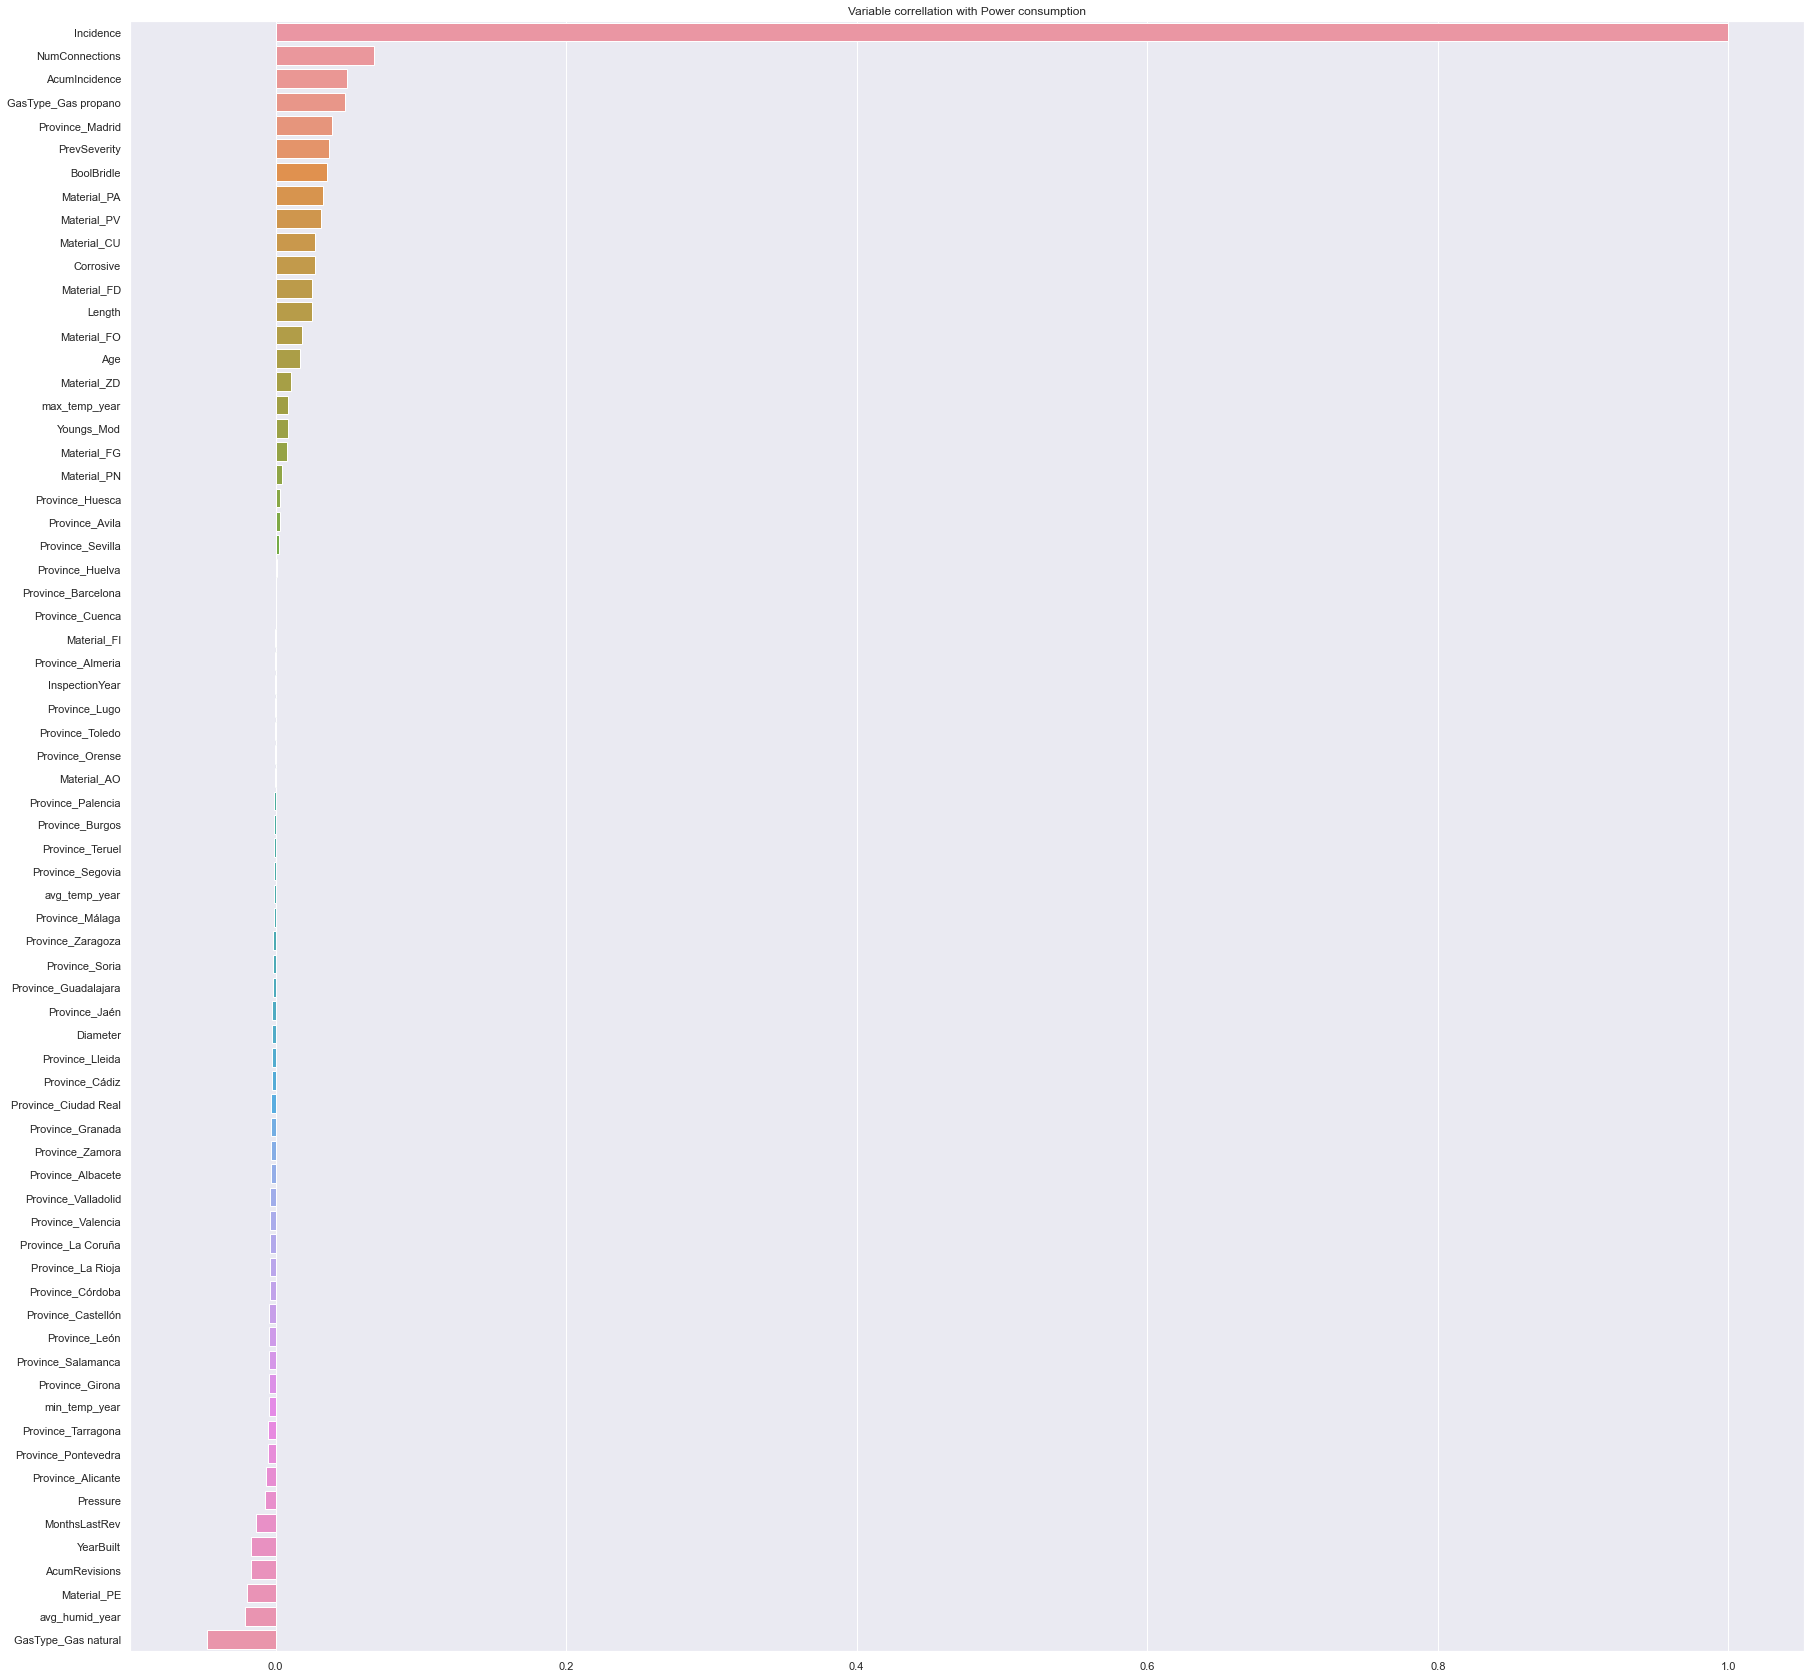

In [286]:
# Correlation of new columns
correlations = df.corr()['Incidence'].sort_values(ascending=False)
meaningful_vars = []
corr = []
for i in range(len(correlations.index)):
    meaningful_vars.append(correlations.index[i])
    corr.append(correlations[i])
sns.barplot(x=corr, y=meaningful_vars)
plt.title('Variable correllation with Power consumption')
sns.set(rc={'figure.figsize':(30,30)})

In [287]:
low_corr_list = [index for index in correlations.index if abs(correlations[index])<0.001]
low_corr_list

['Province_Barcelona',
 'Province_Cuenca',
 'Material_FI',
 'Province_Almeria',
 'InspectionYear',
 'Province_Lugo',
 'Province_Toledo',
 'Province_Orense',
 'Material_AO',
 'Province_Palencia',
 'Province_Burgos',
 'Province_Teruel']

In [288]:
correlations

Incidence              1.000000
NumConnections         0.068092
AcumIncidence          0.049491
GasType_Gas propano    0.047500
Province_Madrid        0.039163
                         ...   
YearBuilt             -0.016705
AcumRevisions         -0.017012
Material_PE           -0.019435
avg_humid_year        -0.021011
GasType_Gas natural   -0.047500
Name: Incidence, Length: 70, dtype: float64

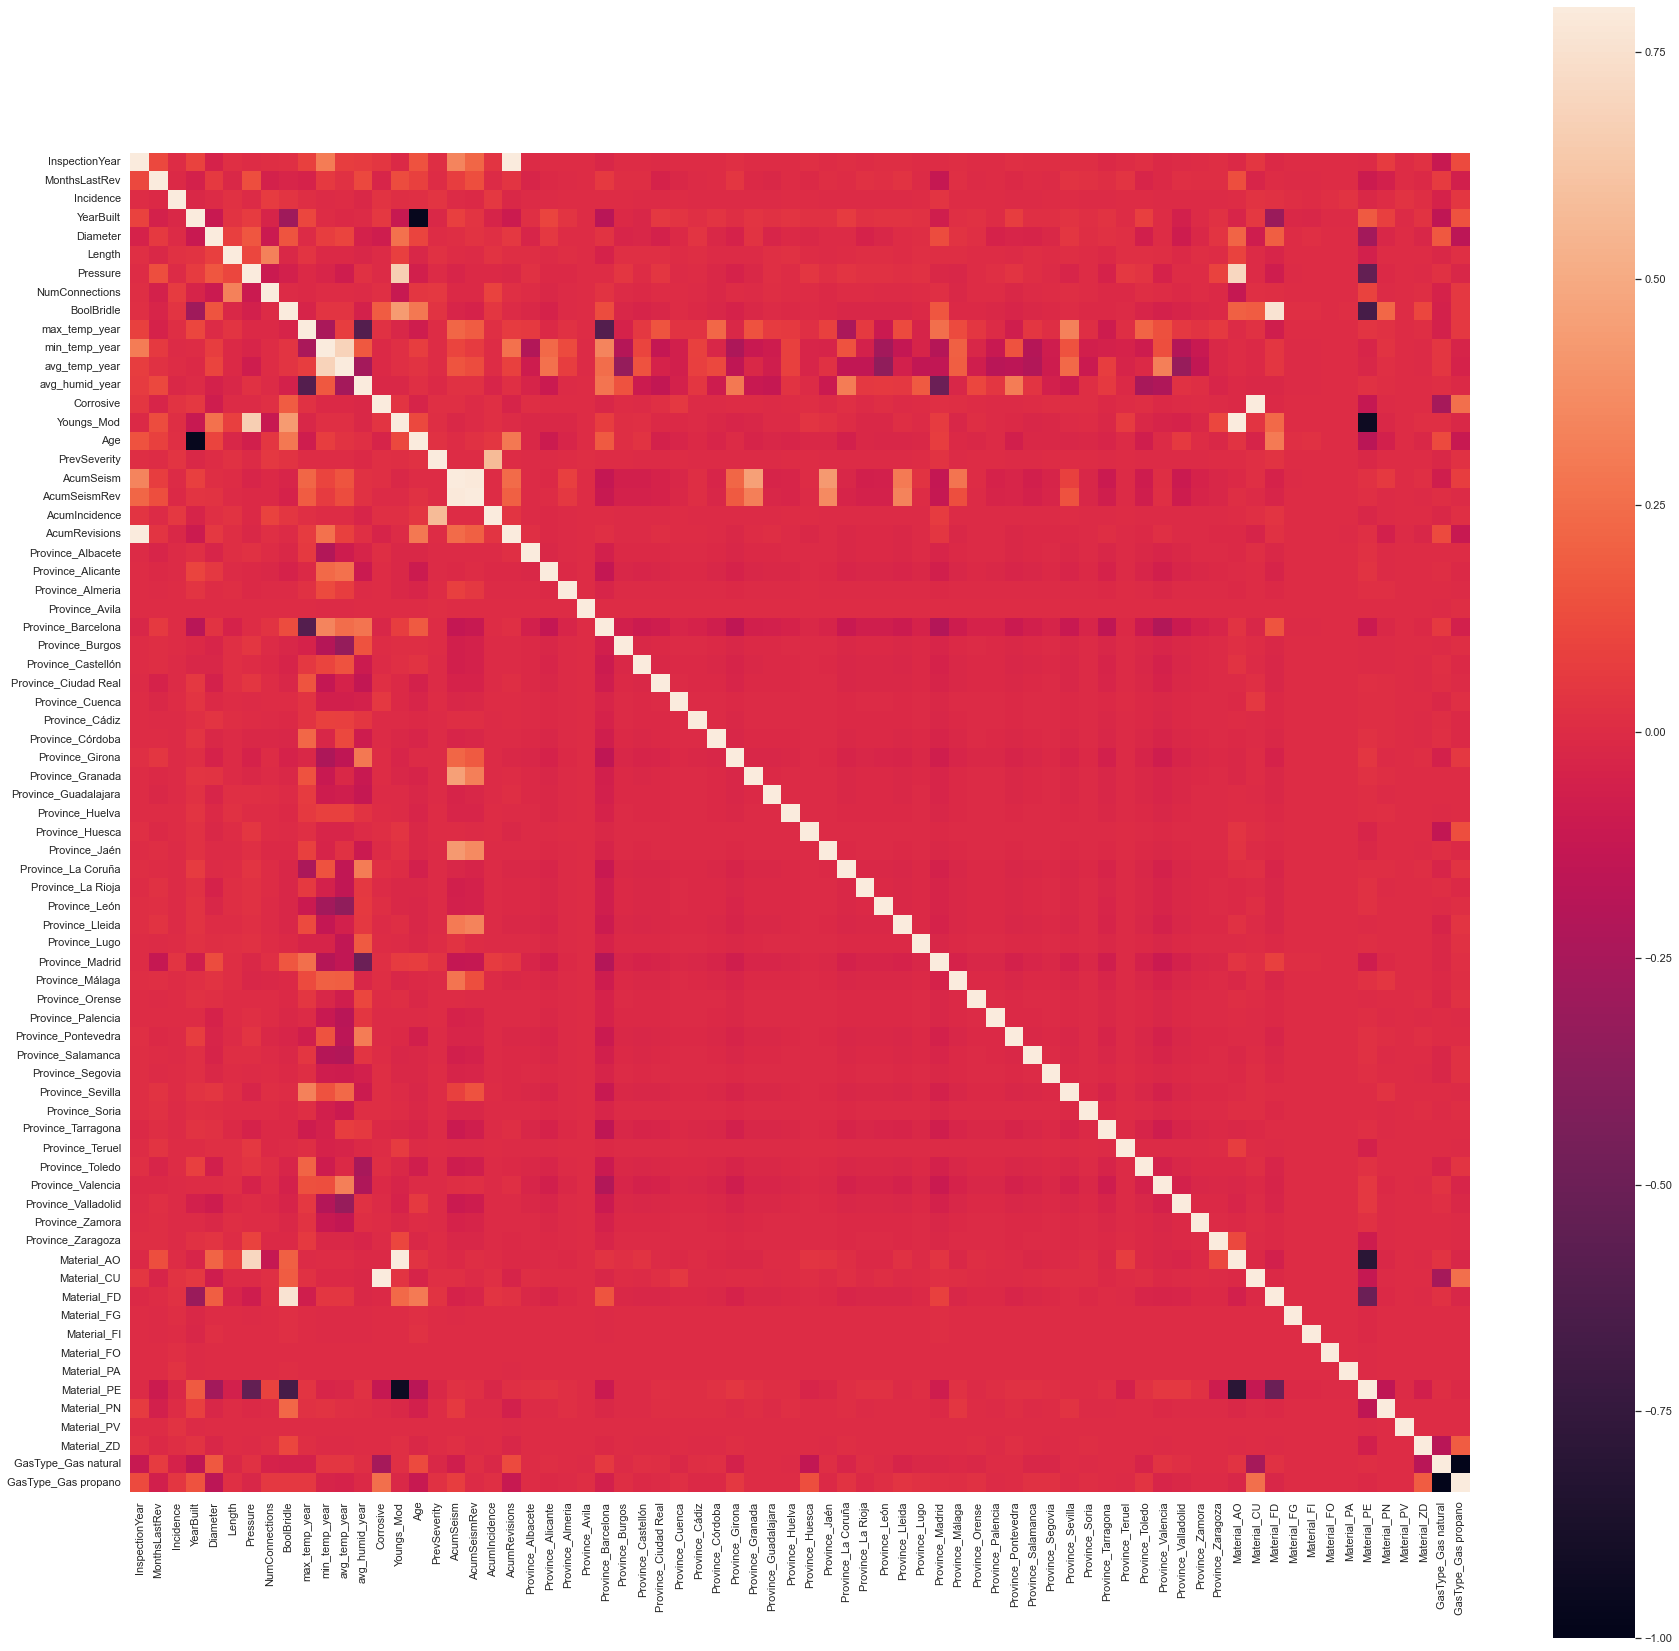

In [289]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(corrmat, vmax=.8, square=True);